In [4]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

In [5]:
def computeLocalPUDensity(all_events_vertex_zs, delta_z):
    localPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        localPUdensity.append((np.sum(np.abs(vertex_zs[0]-vertex_zs[1:]) < delta_z))/(2*delta_z))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_zs, mu=200, sigma_z=50):
    avgPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        avgPUdensity.append(mu/(sigma_z*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_zs[0]**2/sigma_z**2))
    return avgPUdensity

In [204]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/hist-Rel21sample.root']
track_t = np.array([], dtype='object')
track_z0 = np.array([], dtype='object')
track_z0_var = np.array([], dtype='object')
track_z = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_z0 = np.concatenate((track_z0, tree['track_z0'].array(library='np')))
            track_z0_var = np.concatenate((track_z0_var, tree['track_var_z0'].array(library='np')))
            track_z = np.concatenate((track_z, tree['track_z'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))

In [102]:
track_z_flat = np.concatenate(track_z)
track_z0_flat = np.concatenate(track_z0)
diff_track_z = track_z0_flat-track_z_flat

delta_track_z_recoHS = np.array([])
delta_track_z_truthHS = np.array([])
for idx in range(len(track_z)):
    reco_idx = reco_vertex_track_idxs[idx][0]
    truth_idx = truth_vertex_track_idxs[idx][0]
    delta_track_z_recoHS = np.concatenate((delta_track_z_recoHS, track_z[idx][reco_idx] - track_z0[idx][reco_idx]))
    delta_track_z_truthHS = np.concatenate((delta_track_z_truthHS, track_z[idx][truth_idx] - track_z0[idx][truth_idx]))

Text(0.5, 0, 'Reco track z0 - truth track z [mm]')

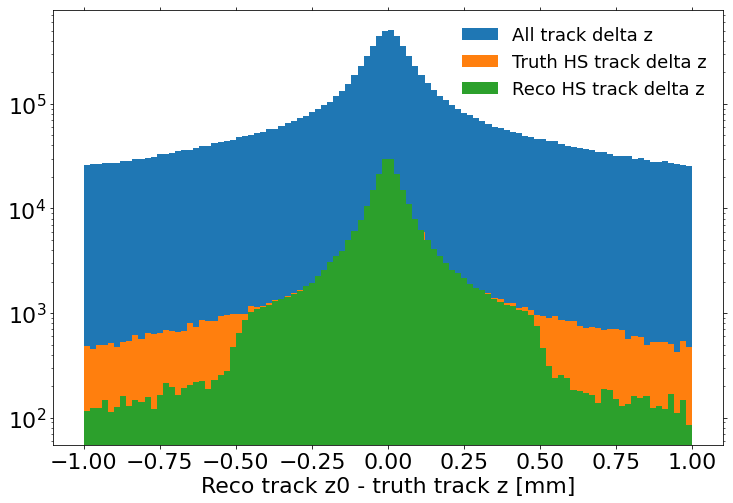

In [115]:
max_z = 1
_ = plt.hist(diff_track_z[np.abs(diff_track_z) < max_z], bins=100, label='All track delta z')
_ = plt.hist(delta_track_z_truthHS[np.abs(delta_track_z_truthHS) < max_z], bins=100, label='Truth HS track delta z')
_ = plt.hist(delta_track_z_recoHS[np.abs(delta_track_z_recoHS) < max_z], bins=100, label='Reco HS track delta z')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Reco track z0 - truth track z [mm]')

In [ ]:
# cut >1 track pT
# plot vs track eta

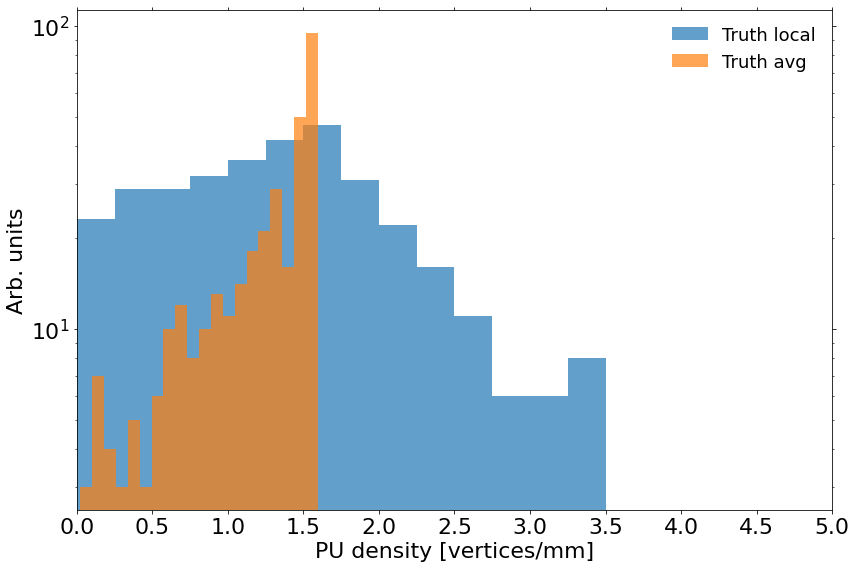

In [131]:
delta_z = 2
truth_localPU = computeLocalPUDensity(truth_vertex_z, delta_z)
reco_localPU = computeLocalPUDensity(reco_vertex_z,   delta_z)

truth_avgPU = computeAvgPUDensity(truth_vertex_z)
reco_avgPU = computeAvgPUDensity(reco_vertex_z)

binwidth = 1/(2*delta_z)

_, truth_bin_edges, _ = plt.hist(truth_localPU, bins=np.arange(np.min(truth_localPU), np.max(truth_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Truth local')
# _, reco_bin_edges, _  = plt.hist(reco_localPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco local')

_, truth_avg_bin_edges, _ = plt.hist(truth_avgPU, bins=20, density=False, alpha=0.7, label='Truth avg')
# _, reco_avg_bin_edges, _  = plt.hist(reco_avgPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco avg')

# plt.text(0.1, 1900, 'Local PU $\\Delta z = {}$ mm'.format(delta_z), fontsize=22)

plt.xlabel('PU density [vertices/mm]')
plt.ylabel('Arb. units')
plt.yscale('log')
plt.xticks(np.arange(0, 10, 0.5))
plt.xlim(0, 5)
plt.legend(frameon=False)
plt.tight_layout()

In [172]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))
    
closest_truth_localPU_bins_delta_zs = []
closest_truth_localPU_bins_delta_z_rms_all = []
closest_truth_localPU_bins_vtx_z_res = []

closest_truth_localPU_bins_delta_z_weighted_rms_all = []
closest_truth_localPU_bins_vtx_z_weighted_res = []

w_cut = 0.9

closest_truth_localPU_bins_w_cut_delta_zs = []
closest_truth_localPU_bins_w_cut_delta_z_rms_all = []
closest_truth_localPU_bins_w_cut_vtx_z_res = []

for event_idxs in events_in_PU_bins:
    
    bin_closest_truth_delta_zs = np.array([])
    bin_closest_truth_delta_z_rms = []
    bin_closest_truth_delta_z_weighted_rms = []
    bin_closest_truth_n_tracks = []
    
    bin_closest_truth_w_cut_delta_zs = np.array([])
    bin_closest_truth_w_cut_delta_z_rms = []
    bin_closest_truth_w_cut_n_tracks = []
    
    for event_idx in event_idxs:
        event_idx = event_idx[0]
        reco_track_weights = reco_vertex_track_weights[event_idx][0]
        
        reco_vtx_z = reco_vertex_z[event_idx][0]
        closest_truth_z = truth_vertex_z[event_idx][np.argmin(np.abs(truth_vertex_z[event_idx] - reco_vtx_z))]
        
        delta_zs = track_z0[event_idx][reco_vertex_track_idxs[event_idx][0]] - closest_truth_z

        bin_closest_truth_delta_zs = np.concatenate((bin_closest_truth_delta_zs, delta_zs))
        bin_closest_truth_delta_z_rms.append(np.sqrt(np.mean(delta_zs**2)))
        bin_closest_truth_delta_z_weighted_rms.append(np.sqrt(np.average(delta_zs**2, weights=reco_track_weights)))
        bin_closest_truth_n_tracks.append(len(delta_zs))
        
        cut_idx = np.array(reco_track_weights) > w_cut
        bin_closest_truth_w_cut_delta_zs = np.concatenate((bin_closest_truth_delta_zs, delta_zs[cut_idx]))
        bin_closest_truth_w_cut_delta_z_rms.append(np.sqrt(np.average(delta_zs[cut_idx]**2)))
        bin_closest_truth_w_cut_n_tracks.append(len(delta_zs[cut_idx]))
        
    closest_truth_localPU_bins_delta_zs.append(bin_closest_truth_delta_zs)
    closest_truth_localPU_bins_delta_z_rms_all.append(bin_closest_truth_delta_z_rms)
    closest_truth_localPU_bins_vtx_z_res.append(np.mean(bin_closest_truth_delta_z_rms / np.sqrt(np.array(bin_closest_truth_n_tracks))))
    closest_truth_localPU_bins_delta_z_weighted_rms_all.append(bin_closest_truth_delta_z_weighted_rms)
    closest_truth_localPU_bins_vtx_z_weighted_res.append(np.mean(bin_closest_truth_delta_z_weighted_rms / np.sqrt(np.array(bin_closest_truth_n_tracks))))
    
    closest_truth_localPU_bins_w_cut_delta_zs.append(bin_closest_truth_w_cut_delta_zs)
    closest_truth_localPU_bins_w_cut_delta_z_rms_all.append(bin_closest_truth_w_cut_delta_z_rms)
    closest_truth_localPU_bins_w_cut_vtx_z_res.append(np.nanmean(bin_closest_truth_w_cut_delta_z_rms / np.sqrt(np.array(bin_closest_truth_w_cut_n_tracks))))

Text(0.5, 0, 'Reco vtx track z - nearest truth vtx z [mm] ')

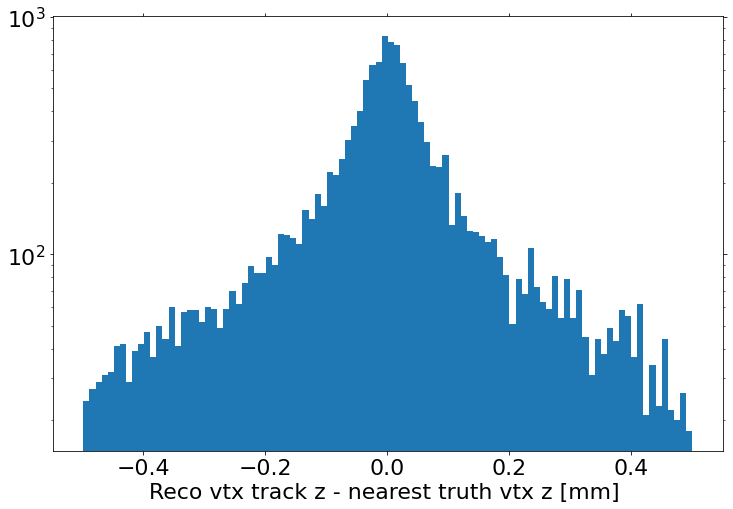

In [181]:
closest_truth_localPU_bins_delta_zs_flat = np.concatenate(closest_truth_localPU_bins_delta_zs)
_  = plt.hist(closest_truth_localPU_bins_delta_zs_flat[np.abs(closest_truth_localPU_bins_delta_zs_flat) < 0.5], bins=100)
plt.yscale('log')
plt.xlabel('Reco vtx track z - nearest truth vtx z [mm] ')

In [ ]:
# fit core of gaussian
# plot sigma and rms
# see delta z w/o cut

# vertex z from avg track z w and w/o cut  

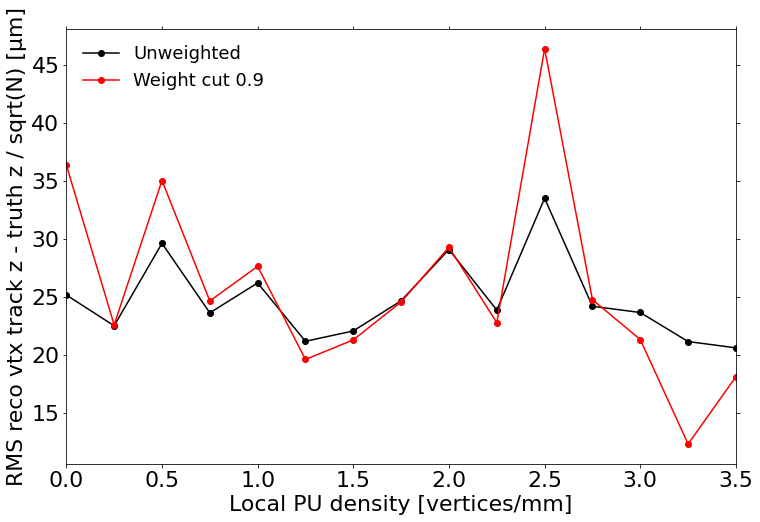

In [212]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_vtx_z_weighted_res), 'ko-', label='Unweighted')
# plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_vtx_z_res), 'bo-', label='Weighted avg')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_w_cut_vtx_z_res), 'ro-', label='Weight cut {}'.format(w_cut))


plt.xlim(0, 3.5)
# plt.ylim(0, 50)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('RMS reco vtx track z - truth z / sqrt(N) [µm]')
plt.legend(frameon=False)

In [ ]:
# resolution vs distance to the closest truth vertex
# split into different eta regions

In [193]:
30e-3 * 30**0.5

0.16431676725154984

In [205]:
track_z0_var_recoHS = np.array([])
track_z0_var_truthHS = np.array([])
for idx in range(len(reco_vertex_track_idxs)):
    track_z0_var_recoHS = np.concatenate((track_z0_var_recoHS, track_z0_var[idx][reco_vertex_track_idxs[idx][0]]))
    track_z0_var_truthHS = np.concatenate((track_z0_var_truthHS, track_z0_var[idx][truth_vertex_track_idxs[idx][0]]))

Text(0.5, 0, 'track sigma_z0 [mm]')

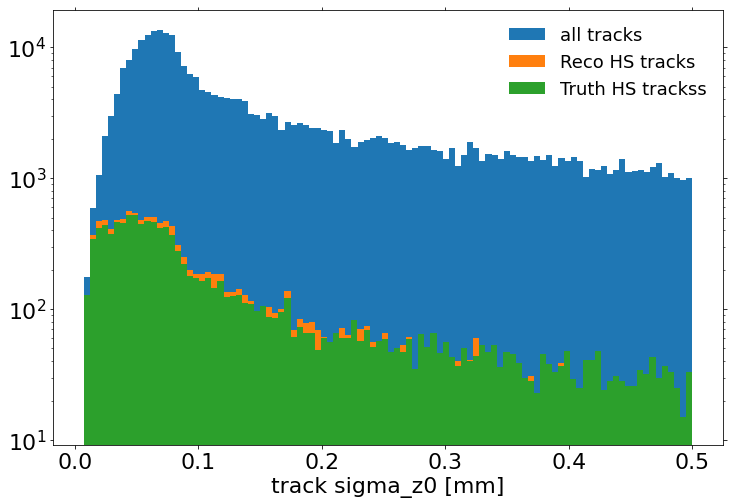

In [210]:
max_sigma = 0.5**2
_ = plt.hist(np.concatenate(track_z0_var)[np.concatenate(track_z0_var) < max_sigma]**0.5, bins=100, label='all tracks')
_ = plt.hist(track_z0_var_recoHS[track_z0_var_recoHS < max_sigma]**0.5, bins=100, label='Reco HS tracks')
_ = plt.hist(track_z0_var_truthHS[track_z0_var_truthHS < max_sigma]**0.5, bins=100, label='Truth HS trackss')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('track sigma_z0 [mm]')